In [40]:
require(data.table)
require(reshape2)
require(ggplot2)

In [55]:
#Importing data set with Country and Brand

inDB = data.table(read.csv("adverity.csv"))
inDB[is.na(inDB)] <- 0 #Replacing every NaN with zero
inDB = inDB[Datasource != "Sizmek Sas"]

In [56]:
#Format specifications ------------------------------
## Date
inDB$Daily = as.Date(inDB$Daily, format = "%m/%d/%Y")
inDB$Month = format(inDB$Daily, format="%Y-%m")

inDB$Quarter = quarter(inDB$Daily)
inDB$Year = as.numeric(format(inDB$Daily, format="%y"))

## Country
get_country = function(camp){
    s = strsplit(camp, "_")[[1]][3]
    return(s)
}
inDB$Country = apply(inDB[,"Campaign.Name"], 1, get_country)
inDB[Country == "Brasil", Country:= "BRA"]
inDB[Country == "Several", Country:= "CENAM"]
inDB = inDB[!is.na(Country)]
inDB = inDB[Platform.Cost.... > 0]
country_list = inDB[, .(.N), by = Country]$Country

inDB[Country %like%"MEX|ARG|COL|LATAM", Region:="LATAM"]
inDB[Country=="BRA", Region:="BRA"]
inDB[Country %like% "PRI|GTM|PAN|CRI|DOM|SLV|ECU|HND|ANDINO|MERCOSUR|CENAM|JAM|NIC|BHS|BMU", Region:="CENAM"]

In [57]:
# Cost Model Definitions --------------------------------------------
## Cost Type in function on campaign naming
cost_type = function(camp_s){
    type = "undefined"
    if (camp_s %like% "CPM"){
        type = "CPM"
    }
    if (camp_s %like% "CPV"){
        type = "CPV"
    }
    if (camp_s %like% "CPCV"){
        type = "CPCV"
    }
    if (camp_s %like% "CPE"){
        type = "CPE"
    }
    if (camp_s %like% "CPC_"){
        type = "CPC"
    }
    return(type)
}

cost_kpi = function(camp_s){
    type = "undefined"
    if (camp_s %like% "CPM"){
        type = "Impressions"
    }
    if (camp_s %like% "CPV"){
        type = "Video Views"
    }
    if (camp_s %like% "CPCV"){
        type = "Video Completions"
    }
    if (camp_s %like% "CPE"){
        type = "Engagements"
    }
    if (camp_s %like% "CPC_"){
        type = "Clicks"
    }
    return(type)
}

inDB[,"Cost.Type"] = apply(inDB[, "Campaign.Name"], 1, cost_type)
inDB[,"Cost.KPI"] = apply(inDB[, "Campaign.Name"], 1, cost_kpi)
inDB[, "Unit.KPI"] = as.numeric(0.0)

# KPI unit in function of costype and campaign naming

inDB[Campaign.Name %like% "Awareness", Cost.Type := "CPM"]
inDB[Campaign.Name %like% "Views", Cost.Type := "CPV"]
inDB[Campaign.Name %like% "Clicks|Clics", Cost.Type := "CPE"]


inDB[Cost.Type == "CPCV", Unit.KPI:=as.numeric(inDB[Cost.Type =="CPCV", Video.Completions])]
inDB[Cost.Type == "CPC", Unit.KPI:=as.numeric(inDB[Cost.Type =="CPC", Clicks])]
inDB[Cost.Type == "CPV", Unit.KPI:=as.numeric(inDB[Cost.Type =="CPV", Video.Views])]
inDB[Cost.Type == "CPM", Unit.KPI:=as.numeric(inDB[Cost.Type =="CPM", Impressions])]
inDB[Cost.Type == "CPE", Unit.KPI:=as.numeric(inDB[Cost.Type =="CPE", Engagements])]

## General formatting of cost model
inDB[,"Unit.Cost"] = 0
inDB[Cost.Type == "CPM", Unit.Cost:=as.numeric(Platform.Cost....*1000/Unit.KPI)] #cost per millar asignation por CPM campaigns
inDB[Cost.Type != "CPM", Unit.Cost:=as.numeric(Platform.Cost..../Unit.KPI)]

inDB = inDB[Cost.Type != "undefined"] # avoiding NaNs and Undefined
inDB[is.na(inDB)] <- 0

## Central Values estimation - by Quarter

Values:
- Datasource
- Region
- Cost Type
- Year
- Quarter

are defined as key values por central values estimation. Country and Brand are deprecated to avoid data format discrepancy.

In [58]:
# Defining a comparative array for each quarter
comparativeData = inDB[, .(Central.KPI=median(Unit.KPI), Central.Cost=median(Unit.Cost)
                           , Central.Impressions = median(Impressions)
                           , Central.Clicks = median(Clicks)
                           , Central.Video.Views = median(Video.Views)
                           , Central.Video.Completions = median(Video.Completions)
                           , Central.Engagements = median(Engagements)
                          ), 
                       by=c("Datasource","Region", "Cost.Type","Year","Quarter")]

In [59]:
comparativeData[, Quarter:=Quarter+1] #setting the comparative quarter equal to the analized one
comparativeData[Quarter==5, Year:= as.numeric(Year)+1]
comparativeData[Quarter==5, Quarter:= 1] #checkin values are just correct (last quarter = 5 equals to the first quarter of the next year)

In [60]:
#joining the dataset with the estimated central values for the defined key values
mergedData = merge(inDB, comparativeData, by=c("Datasource","Region","Cost.Type","Year","Quarter"), allow.cartesian=TRUE)

In [61]:
# Calculating primary evaluations: KPI and Costs
mergedData$KPI.Eval = mergedData$Unit.KPI / mergedData$Central.KPI
mergedData$Cost.Eval = mergedData$Unit.Cost / mergedData$Central.Cost

#Calculating secondary ecaluation: extraordinary results
mergedData$Clicks.Eval = (mergedData$Clicks / mergedData$Central.Clicks)
mergedData$Impressions.Eval = (mergedData$Impressions / mergedData$Central.Impressions)
mergedData$Video.Completions.Eval = (mergedData$Video.Completions / mergedData$Central.Video.Completions)
mergedData$Video.Views.Eval = (mergedData$Video.Views / mergedData$Central.Video.Views)
mergedData$Engagements.Eval = (mergedData$Engagements / mergedData$Central.Engagements)

#Avoiding null data
mergedData[is.na(mergedData)] = 0
mergedData$Second.Eval = 0

# Calculationg Secondary evaluations for each cost type
mergedData[Cost.Type == "CPE", Second.Eval := (Impressions.Eval + Clicks.Eval + Video.Views.Eval + Video.Completions.Eval)*0.20]
mergedData[Cost.Type == "CPM", Second.Eval := (Engagements.Eval + Clicks.Eval + Video.Views.Eval + Video.Completions.Eval)*0.20]
mergedData[Cost.Type == "CPV", Second.Eval := (Impressions.Eval + Clicks.Eval + Engagements.Eval + Video.Completions.Eval)*0.20]
mergedData[Cost.Type == "CPCV", Second.Eval := (Impressions.Eval + Clicks.Eval + Video.Views.Eval + Engagements.Eval)*0.20]

#Avoiding null data
mergedData[is.infinite(mergedData$Second.Eval), Second.Eval := 0]

In [62]:
# Total Evaluation is calculated and INF values are set to 0
mergedData$Total.Eval = mergedData$KPI.Eval + mergedData$Second.Eval - mergedData$Cost.Eval
mergedData[is.infinite(mergedData$Total.Eval), Total.Eval := 0]

In [63]:
# Rescaling the Evaluation column to a readable index
minCalibratingValue = min(mergedData$Total.Eval)
mergedData[, Total.Eval := Total.Eval - minCalibratingValue]

maxCalibratingValue = median(mergedData$Total.Eval)
mergedData[, Total.Eval := log(Total.Eval)]
mergedData[is.infinite(mergedData$Total.Eval), Total.Eval := 0]

TestingB = mergedData[, .(KWIN.B = mean(Total.Eval)), by=c("Campaign.Name")][order(KWIN.B)]

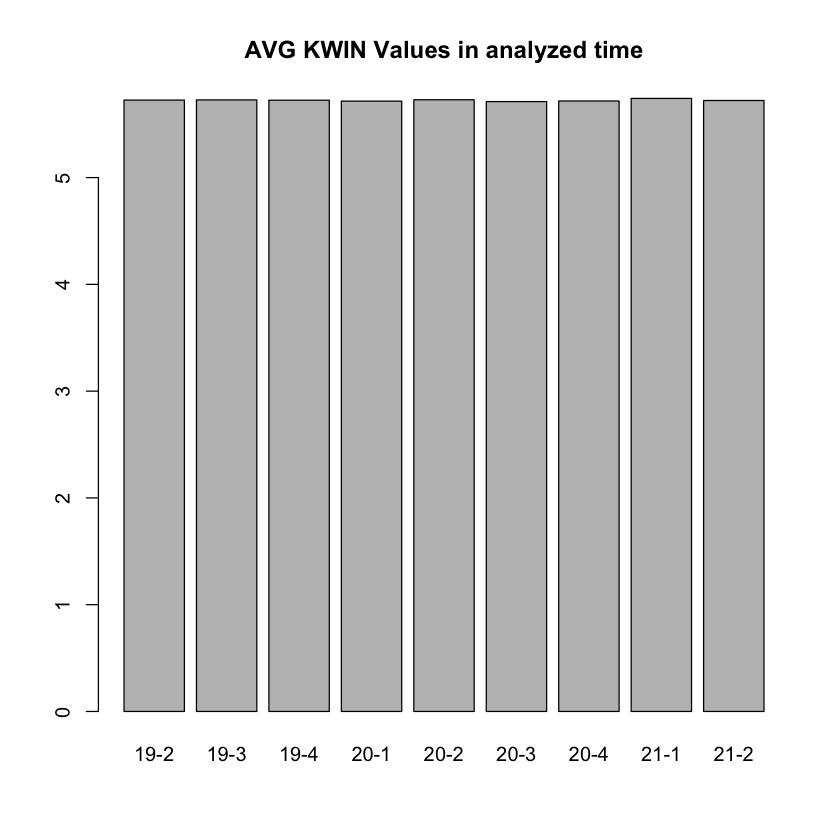

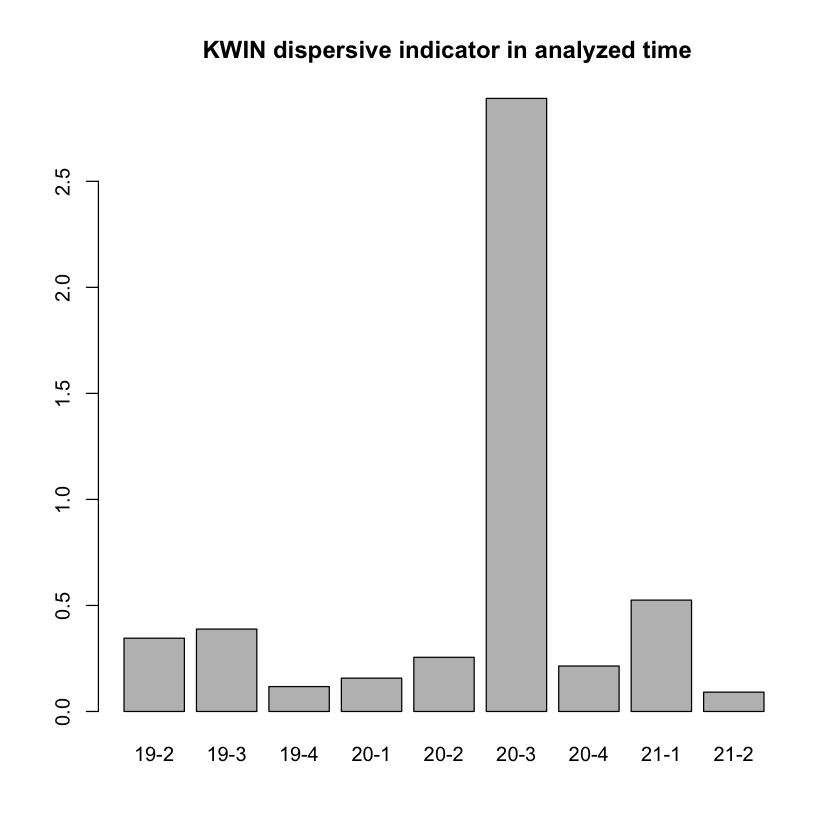

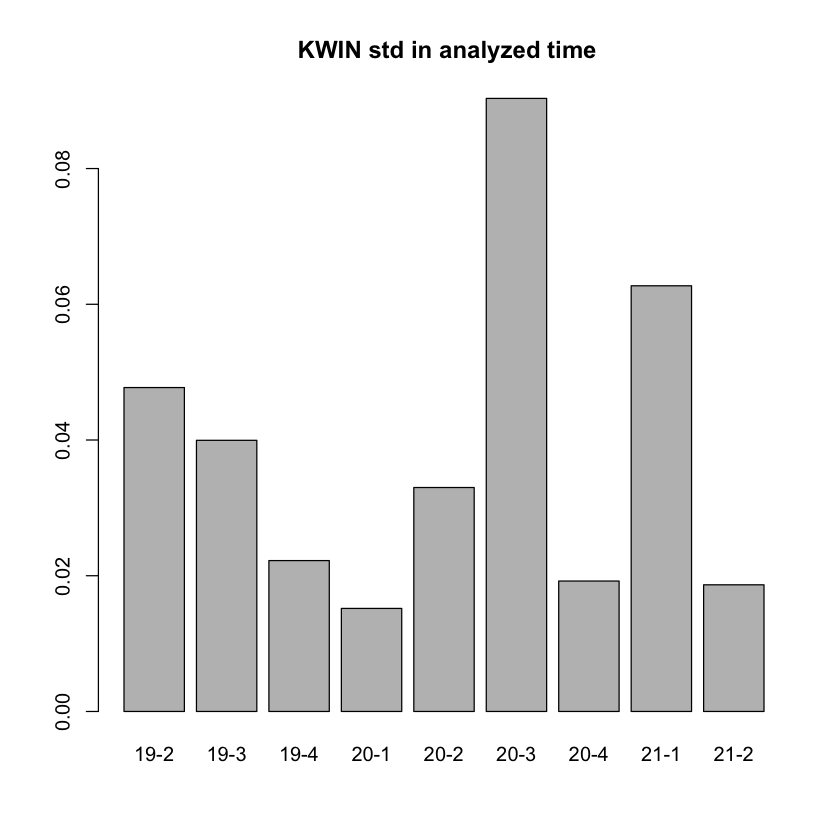

In [64]:
mergedData$Com.Range = paste(mergedData$Year, mergedData$Quarter, sep="-")

Test1 = mergedData[, .(minEval=min(Total.Eval), maxEval=max(Total.Eval),centralEval=mean(Total.Eval), stdEval = sd(Total.Eval) ), by=c("Com.Range")][order(Com.Range)]
Test1$disEval = (abs(Test1$minEval - Test1$centralEval) + abs(Test1$maxEval - Test1$centralEval))/2

barplot(Test1$centralEval, names.arg=Test1$Com.Range, main="AVG KWIN Values in analyzed time")

barplot(Test1$disEval, names.arg=Test1$Com.Range, main=" KWIN dispersive indicator in analyzed time")
barplot(Test1$stdEval, names.arg=Test1$Com.Range, main=" KWIN std in analyzed time")

- El valor promedio de la métrica KWIN parece estable en el tiempo, a lo largo de los diferentes trimestres. Un Benchmarking anual es posible.
- Durante los primeros Qs crecen los indicadores de dispersión de la métrica. Una mayor variabilidad puede indicar: 1) una mayor variedad en las campañas de ese periodo, 2) hay un cierto grado de impredictibilidad debido a circunstancias externas.
- Hay un pico de incertidumbre durante el primer trimestre del 20 debido al inicio de la pandemia que se estabiliza a lo largo de los siguientes Qs.

In [65]:
mergedData

Datasource,Region,Cost.Type,Year,Quarter,Daily,Campaign.Name,Brand,Platform.Cost....,Impressions,⋯,KPI.Eval,Cost.Eval,Clicks.Eval,Impressions.Eval,Video.Completions.Eval,Video.Views.Eval,Engagements.Eval,Second.Eval,Total.Eval,Com.Range
<chr>,<chr>,<chr>,<dbl>,<int>,<date>,<chr>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Facebook Ads Insights,0,CPC,21,2,2021-04-01,MCMMIA_2021_CHL_KELLOGGS_MASTERBRAND_SEASONAL_DESPIERTAMUCHOMAS_FACEBOOK_FACEBOOKANDINSTAGRAM_WEBSITECLICKS_CPC_BREAKFASTFORONE,Masterbrand,25.85000,14725,⋯,0.7212875,0.9322644,0.7212875,0.8282010,0.7051040,0.8029346,0.7884363,0.000000,5.712689,21-2
Facebook Ads Insights,0,CPC,21,2,2021-04-02,MCMMIA_2021_CHL_KELLOGGS_MASTERBRAND_SEASONAL_DESPIERTAMUCHOMAS_FACEBOOK_FACEBOOKANDINSTAGRAM_WEBSITECLICKS_CPC_BREAKFASTFORONE,Masterbrand,26.91000,16323,⋯,0.7973665,0.8778952,0.7973665,0.9180798,2.3667297,1.9176686,1.7128778,0.000000,5.713120,21-2
Facebook Ads Insights,0,CPC,21,2,2021-04-03,MCMMIA_2021_CHL_KELLOGGS_MASTERBRAND_SEASONAL_DESPIERTAMUCHOMAS_FACEBOOK_FACEBOOKANDINSTAGRAM_WEBSITECLICKS_CPC_BREAKFASTFORONE,Masterbrand,26.08000,18316,⋯,1.1119239,0.6101259,1.1119239,1.0301752,3.7542533,2.5257795,2.2739816,0.000000,5.715041,21-2
Facebook Ads Insights,0,CPC,21,2,2021-04-04,MCMMIA_2021_CHL_KELLOGGS_MASTERBRAND_SEASONAL_DESPIERTAMUCHOMAS_FACEBOOK_FACEBOOKANDINSTAGRAM_WEBSITECLICKS_CPC_BREAKFASTFORONE,Masterbrand,24.21000,16304,⋯,1.0826628,0.5816859,1.0826628,0.9170112,3.5387524,2.4210312,2.1829829,0.000000,5.715038,21-2
Facebook Ads Insights,0,CPC,21,2,2021-04-05,MCMMIA_2021_CHL_KELLOGGS_MASTERBRAND_SEASONAL_DESPIERTAMUCHOMAS_FACEBOOK_FACEBOOKANDINSTAGRAM_WEBSITECLICKS_CPC_BREAKFASTFORONE,Masterbrand,23.61000,13470,⋯,0.8061448,0.7618507,0.8061448,0.7576141,2.1323251,1.4228653,1.3147175,0.000000,5.713532,21-2
Facebook Ads Insights,0,CPC,21,2,2021-04-06,MCMMIA_2021_CHL_KELLOGGS_MASTERBRAND_SEASONAL_DESPIERTAMUCHOMAS_FACEBOOK_FACEBOOKANDINSTAGRAM_WEBSITECLICKS_CPC_BREAKFASTFORONE,Masterbrand,24.45000,15763,⋯,0.9992685,0.6364783,0.9992685,0.8865829,2.2911153,1.7024659,1.5854139,0.000000,5.714583,21-2
Facebook Ads Insights,0,CPC,21,2,2021-04-07,MCMMIA_2021_CHL_KELLOGGS_MASTERBRAND_SEASONAL_DESPIERTAMUCHOMAS_FACEBOOK_FACEBOOKANDINSTAGRAM_WEBSITECLICKS_CPC_BREAKFASTFORONE,Masterbrand,25.99000,16646,⋯,1.0724214,0.6304168,1.0724214,0.9362468,2.6275992,2.0505400,1.8794350,0.000000,5.714844,21-2
Facebook Ads Insights,0,CPC,21,2,2021-04-08,MCMMIA_2021_CHL_KELLOGGS_MASTERBRAND_SEASONAL_DESPIERTAMUCHOMAS_FACEBOOK_FACEBOOKANDINSTAGRAM_WEBSITECLICKS_CPC_BREAKFASTFORONE,Masterbrand,25.67000,17426,⋯,0.8822238,0.7568922,0.8822238,0.9801176,1.9319471,1.7966171,1.6327201,0.000000,5.713799,21-2
Facebook Ads Insights,0,CPC,21,2,2021-04-09,MCMMIA_2021_CHL_KELLOGGS_MASTERBRAND_SEASONAL_DESPIERTAMUCHOMAS_FACEBOOK_FACEBOOKANDINSTAGRAM_WEBSITECLICKS_CPC_BREAKFASTFORONE,Masterbrand,27.35000,12310,⋯,0.8880761,0.8011136,0.8880761,0.6923704,2.7561437,1.8654983,1.6938239,0.000000,5.713673,21-2


In [70]:
mergedData[order(-Total.Eval)]

Datasource,Region,Cost.Type,Year,Quarter,Daily,Campaign.Name,Brand,Platform.Cost....,Impressions,⋯,KPI.Eval,Cost.Eval,Clicks.Eval,Impressions.Eval,Video.Completions.Eval,Video.Views.Eval,Engagements.Eval,Second.Eval,Total.Eval,Com.Range
<chr>,<chr>,<chr>,<dbl>,<int>,<date>,<chr>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Google Adwords,LATAM,CPC,19,3,2019-08-17,MCMMIA_2019_MEX_KELLOGGS_PRINGLES_SEASONAL_GOOGLE_GDN_MUSIC_AFFINITYAUDIENCES_CPC_EVENINGME,Pringles,1298.1495,2029210,⋯,346.270270,0.61268096,346.270270,3433.519459,0.000000,0.000000,0.00000,0.00000,6.474743,19-3
Google Adwords,CENAM,CPV,21,1,2021-02-12,MCMMIA_2021_PRI_KELLOGGS_CORPORATEPROMOTIONS_SEASONAL_GOOGLE_YOUTUBE_365BOWLS_AFFINITYAUDIENCES_CPV_BREAKFASTFORONE,Corporate Promotions,1106.3590,368741,⋯,7.105940,2.12825720,11.733333,9.868884,5.789376,7.105940,935.55963,192.59025,6.215533,21-1
Google Adwords,LATAM,CPC,19,3,2019-08-14,MCMMIA_2019_MEX_KELLOGGS_PRINGLES_SEASONAL_GOOGLE_GDN_MUSIC_AFFINITYAUDIENCES_CPC_EVENINGME,Pringles,708.6386,1042606,⋯,182.972973,0.63294031,182.972973,1764.138748,0.000000,0.000000,0.00000,0.00000,6.184633,19-3
Google Adwords,LATAM,CPCV,19,2,2019-05-25,MCMMIA_2019_MEX_KELLOGGS_MASTERBRAND_SEASONAL_GOOGLE_YOUTUBE_CEREBRO_AFFINITYAUDIENCES_CPCV_BREAKFASTFORONE,Masterbrand,3271.1306,1392389,⋯,133.704884,0.65996015,47.200000,71.772629,133.704884,100.634545,0.00000,43.92143,6.173497,19-2
Google Adwords,LATAM,CPCV,19,2,2019-05-26,MCMMIA_2019_MEX_KELLOGGS_MASTERBRAND_SEASONAL_GOOGLE_YOUTUBE_CEREBRO_AFFINITYAUDIENCES_CPCV_BREAKFASTFORONE,Masterbrand,3272.3470,1353789,⋯,129.848142,0.67981495,52.480000,69.782938,129.848142,97.792375,0.00000,44.01106,6.165574,19-2
Google Adwords,LATAM,CPCV,19,2,2019-05-24,MCMMIA_2019_MEX_KELLOGGS_MASTERBRAND_SEASONAL_GOOGLE_YOUTUBE_CEREBRO_AFFINITYAUDIENCES_CPCV_BREAKFASTFORONE,Masterbrand,3268.1016,1339958,⋯,124.289901,0.70929486,52.880000,69.070000,124.289901,95.154162,0.00000,43.42083,6.152512,19-2
Google Adwords,LATAM,CPC,19,3,2019-08-18,MCMMIA_2019_MEX_KELLOGGS_PRINGLES_SEASONAL_GOOGLE_GDN_MUSIC_AFFINITYAUDIENCES_CPC_EVENINGME,Pringles,679.8134,968097,⋯,161.297297,0.68879113,161.297297,1638.065990,0.000000,0.000000,0.00000,0.00000,6.138814,19-3
Facebook Ads Insights,CENAM,CPE,20,2,2020-05-15,MCMMIA_2020_GTM_KELLOGGS_CORPORATEPROMOTIONS_SEASONAL_COVIDHAGAMOSFAMILIA_FACEBOOK_FACEBOOKANDINSTAGRAM_ENGAGEMENT_CPE_FAMILYBREAKFAST,Corporate Promotions,179.6800,150952,⋯,157.169168,0.02531212,3.425968,4.492218,Inf,Inf,157.16917,0.00000,6.131311,20-2
Google Adwords,LATAM,CPCV,19,2,2019-05-27,MCMMIA_2019_MEX_KELLOGGS_MASTERBRAND_SEASONAL_GOOGLE_YOUTUBE_CEREBRO_AFFINITYAUDIENCES_CPCV_BREAKFASTFORONE,Masterbrand,3279.3089,1211457,⋯,116.881839,0.75683706,53.620000,62.446237,116.881839,87.765589,0.00000,40.76637,6.130762,19-2


In [67]:
write.csv(mergedData, "mergedData.csv", row.names=FALSE)

In [69]:
mergedData = mergedData[Total.Eval >= 0]

Warning message in min(Unit.KPI):
“ningún argumento finito para min; retornando Inf”
Warning message in max(Unit.KPI):
“ningun argumento finito para max; retornando -Inf”
Warning message in min(Unit.KPI):
“ningún argumento finito para min; retornando Inf”
Warning message in max(Unit.KPI):
“ningun argumento finito para max; retornando -Inf”
Warning message in min(x):
“ningún argumento finito para min; retornando Inf”
Warning message in max(x):
“ningun argumento finito para max; retornando -Inf”


ERROR: Error in plot.window(xlim, ylim, log = log, ...): se necesitan valores finitos de 'ylim'


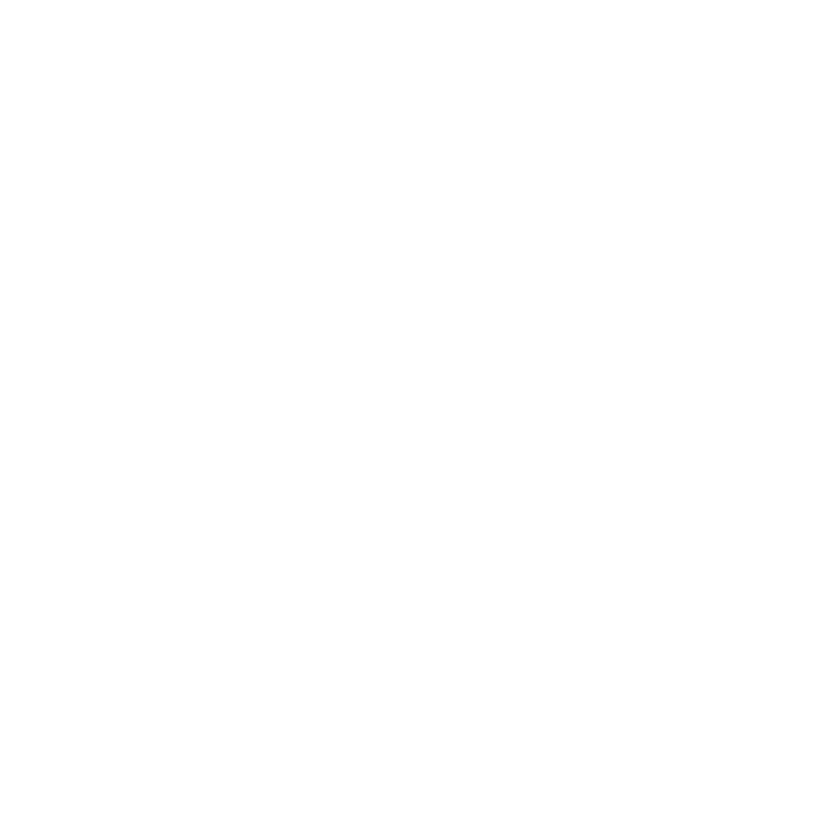

In [13]:
A = inDB[Year==19, .(minKPI = min(Unit.KPI), maxKPI = max(Unit.KPI), centralKPI = mean(Unit.KPI),stdKPI = sd(Unit.KPI)/mean(Unit.KPI), disKPI = mean(abs(Unit.KPI - mean(Unit.KPI)))/Unit.KPI),
     by=c("Datasource","Region","Cost.Type")][order(disKPI)]

B = inDB[Year==19, .(minKPI = min(Unit.KPI), maxKPI = max(Unit.KPI), centralKPI = mean(Unit.KPI),stdKPI = sd(Unit.KPI)/mean(Unit.KPI), disKPI = mean(abs(Unit.KPI - mean(Unit.KPI)))/Unit.KPI), 
     by=c("Datasource","Region","Year","Quarter","Cost.Type")][order(disKPI)]

barplot(c(mean(A$disKPI), mean(B$disKPI)), names.arg=c("TestA: Central Tendencies by Year", "TestB: Central Tendencies by Quarter"), main="Distancia promedio a la media")

In [14]:
write.csv(comparativeData, "central_tendencies.csv", row.names=FALSE)

In [15]:
mergedData[Region == "LATAM" & Datasource == "Google Adwords" & Year == "20" & Cost.Type == "CPV" & Quarter == 3][, 2:35][order(-KPI.Eval)]

Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”


Region,Cost.Type,Year,Quarter,Daily,Campaign.Name,Brand,Kwin.Primary.Factor,Platform.Cost....,Impressions,⋯,Central.Video.Completions,Central.Engagements,KPI.Eval,Cost.Eval,Clicks.Eval,Impressions.Eval,Video.Completions.Eval,Video.Views.Eval,Engagements.Eval,Second.Eval
<chr>,<chr>,<dbl>,<int>,<date>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


## Central Values estimation - by Year

Values:
- Datasource
- Region
- Cost Type
- Year

are defined as key values por central values estimation. Country and Brand are deprecated to avoid data format discrepancy.

In [16]:
# Defining a comparative array for each year
comparativeData = inDB[, .(Central.KPI=median(Unit.KPI), Central.Cost=median(Unit.Cost)
                           , Central.Impressions = median(Impressions)
                           , Central.Clicks = median(Clicks)
                           , Central.Video.Views = median(Video.Views)
                           , Central.Video.Completions = median(Video.Completions)
                           , Central.Engagements = median(Engagements)
                          ), 
                       by=c("Datasource","Region", "Cost.Type","Year")]

comparativeData[, Year:=as.numeric(Year)+1] #setting the comparative year equal to the analized one

#joining the dataset with the estimated central values for the defined key values
mergedData = merge(inDB, comparativeData, by=c("Datasource","Region","Cost.Type","Year"), allow.cartesian=TRUE)

# Calculating primary evaluations: KPI and Costs
mergedData$KPI.Eval = mergedData$Unit.KPI / mergedData$Central.KPI
mergedData$Cost.Eval = mergedData$Unit.Cost / mergedData$Central.Cost

#Calculating secondary ecaluation: extraordinary results
mergedData$Clicks.Eval = (mergedData$Clicks / mergedData$Central.Clicks)
mergedData$Impressions.Eval = (mergedData$Impressions / mergedData$Central.Impressions)
mergedData$Video.Completions.Eval = (mergedData$Video.Completions / mergedData$Central.Video.Completions)
mergedData$Video.Views.Eval = (mergedData$Video.Views / mergedData$Central.Video.Views)
mergedData$Engagements.Eval = (mergedData$Engagements / mergedData$Central.Engagements)

#Avoiding null data
mergedData[is.na(mergedData)] = 0
mergedData$Second.Eval = 0

# Calculationg Secondary evaluations for each cost type
mergedData[Cost.Type == "CPE", Second.Eval := (Impressions.Eval + Clicks.Eval + Video.Views.Eval + Video.Completions.Eval)*0.20]
mergedData[Cost.Type == "CPM", Second.Eval := (Engagements.Eval + Clicks.Eval + Video.Views.Eval + Video.Completions.Eval)*0.20]
mergedData[Cost.Type == "CPV", Second.Eval := (Impressions.Eval + Clicks.Eval + Engagements.Eval + Video.Completions.Eval)*0.20]
mergedData[Cost.Type == "CPCV", Second.Eval := (Impressions.Eval + Clicks.Eval + Video.Views.Eval + Engagements.Eval)*0.20]

#Avoiding null data
mergedData[is.infinite(mergedData$Second.Eval), Second.Eval := 0]

# Total Evaluation is calculated and INF values are set to 0
mergedData$Total.Eval = mergedData$KPI.Eval + mergedData$Second.Eval - mergedData$Cost.Eval
mergedData[is.infinite(mergedData$Total.Eval), Total.Eval := 0]

# Rescaling the Evaluation column to a readable index
minCalibratingValue = min(mergedData$Total.Eval)
mergedData[, Total.Eval := Total.Eval - minCalibratingValue]

maxCalibratingValue = median(mergedData$Total.Eval)
mergedData[, Total.Eval := log(Total.Eval)]
mergedData[is.infinite(mergedData$Total.Eval), Total.Eval := 0]


TestingA = mergedData[, .(KWIN.A = mean(Total.Eval)), by=c("Campaign.Name")][order(KWIN.A)]

In [17]:
testResults = merge(TestingA, TestingB)
testResults$vs.Rate = (testResults$KWIN.B - testResults$KWIN.A)/testResults$KWIN.B
testResults[, Minimal.Punishment.Winner := ifelse(vs.Rate > 0, "KWIN.B", "KWIN.A")]

In [18]:
testResults[, .(.N, AVG.Variation= mean(abs(vs.Rate))), by=Minimal.Punishment.Winner]

Minimal.Punishment.Winner,N,AVG.Variation
<chr>,<int>,<dbl>
KWIN.B,175,0.09555355


In [19]:
nrow(TestingA)
nrow(TestingB)

[1] 194

[1] 341

Utilizar tendencias centrales anuales arroja un resultado en donde KWIN castiga un mayor número de campañas. Descarga las campañas del 2019 porque no tiene con qué compararlas.
Tendencias centrales trimentrales añade más puntos al set de estudio, castiga menos campañas y arroja resultados menos planos.

In [20]:
mean(mergedData[Year==19]$Total.Eval)
mean(mergedData[Year==20]$Total.Eval)

[1] NaN

[1] NaN

In [21]:
TestingB

Campaign.Name,KWIN.B
<chr>,<dbl>
MCMMX_2021_MEX_KELLOGGS_EXTRA_SEASONAL_EXTRADELICE_FACEBOOK_FACEBOOK_VIEWS_CPCV_AFTERNOONSNACK,2.209769
MCMMX_2021_MEX_KELLOGGS_EXTRA_SEASONAL_EXTRADELICE_FACEBOOK_FACEBOOKANDINSTAGRAM_VIEWS_CPCV_AFTERNOONSNACK,4.191548
MCMMX_2021_MEX_KELLOGGS_MASTERBRAND_SEASONAL_DESPIERTAMUCHOMAS_FACEBOOK_FACEBOOKANDINSTAGRAM_VIDEOVIEWS_CPCV_BREAKFASTFORONE,4.371236
MCMMIA_2020_BMU_KELLOGGS_CHEEZIT_SEASONAL_CHEEZIT_FACEBOOK_FACEBOOKANDINSTAGRAM_BRANDING_CPM_AFTERNOONSNACK,4.675321
MCMMX_2021_MEX_KELLOGGS_EXTRA_SEASONAL_EXTRADELICE_FACEBOOK_INSTAGRAM_VIEWS_CPCV_AFTERNOONSNACK,4.726231
MCMMIA_2020_MEX_KELLOGGS_CORPORATEPROMOTIONS_SEASONAL_HAGAMOSFAMILIA_FACEBOOK_FACEBOOK_VIDEOVIEWS_CPCV_FAMILYBREAKFAST,4.730515
MCMMIA_2020_COL_KELLOGGS_EXTRA_SEASONAL_EXTRA_FACEBOOK_FACEBOOKANDINSTAGRAM_WEBSITECLICKS_CPC_BREAKFASTFORONE,4.765788
MCMMIA_2020_MEX_KELLOGGS_EXTRA_SEASONAL_EXTRA_FACEBOOK_INSTAGRAM_WEBSITECLICKS_CPC_BREAKFASTFORONE,4.785416
MCMMIA_2020_MEX_KELLOGGS_POPTARTS_SEASONAL_UGLYSWEATER_FACEBOOK_INSTAGRAM_REACH_CPM_MID-MORNINGSNACK,4.805600


In [22]:
comparativeData

Datasource,Region,Cost.Type,Year,Central.KPI,Central.Cost,Central.Impressions,Central.Clicks,Central.Video.Views,Central.Video.Completions,Central.Engagements
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Facebook Ads Insights,BRA,CPM,21,1407764.0,0.273823240,1407764.0,709.0,25029.0,5161.000,25157.0
Facebook Ads Insights,LATAM,CPM,21,703104.5,0.286440890,703104.5,1290.0,9192.0,3001.000,10058.5
Facebook Ads Insights,CENAM,CPM,21,148274.0,0.460348536,148274.0,272.0,2431.0,496.000,2595.0
Facebook Ads Insights,LATAM,CPC,21,1672.0,0.043493045,100527.0,1672.0,1642.0,933.000,3728.0
Facebook Ads Insights,LATAM,CPE,21,7057.0,0.066685220,149780.0,3882.0,0.0,0.000,7057.0
Facebook Ads Insights,LATAM,CPCV,21,16198.0,0.010536720,213259.5,1164.5,91793.5,16198.000,91947.0
Facebook Ads Insights,CENAM,CPC,21,573.0,0.188513238,77013.0,573.0,1658.0,116.000,2078.0
Facebook Ads Insights,CENAM,CPM,22,121059.5,0.423085903,121059.5,247.0,1986.5,413.000,2207.0
Facebook Ads Insights,BRA,CPM,22,954061.5,0.216688014,954061.5,568.5,8557.0,3944.000,9452.0


In [23]:
inDB[Cost.Type =="CPV" & Datasource == "Google Adwords"][order(Campaign.Name) & Region=="LATAM"]

Datasource,Daily,Campaign.Name,Brand,Kwin.Primary.Factor,Platform.Cost....,Impressions,Clicks,Video.Completions,Engagements,Video.Views,Month,Quarter,Year,Country,Region,Cost.Type,Cost.KPI,Unit.KPI,Unit.Cost
<chr>,<date>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
Google Adwords,2020-09-01,MCMMIA_2020_COL_KELLOGGS_FROOTLOOPS_SEASONAL_GOOGLE_YOUTUBE_FROOTLOOPSJUMBO_AFFINITYAUDIENCES_CPV_MID-MORNINGSNACK,Froot Loops,0,31.81571,35766,41,8217.765,205,16947,2020-09,3,20,COL,LATAM,CPV,Video Views,16947,0.001877365
Google Adwords,2020-09-01,MCMMIA_2020_COL_KELLOGGS_MASTERBRAND_SEASONAL_GOOGLE_YOUTUBE_INCANSABLES_AFFINITYAUDIENCES_CPV_BREAKFASTFORONE,Masterbrand,0,43.47491,48045,65,10999.155,276,22600,2020-09,3,20,COL,LATAM,CPV,Video Views,22600,0.001923669
Google Adwords,2020-09-01,MCMMIA_2020_MEX_KELLOGGS_ZUCARITAS_SEASONAL_GOOGLE_YOUTUBE_EQUITY_AFFINITYAUDIENCES_CPV_FAMILYBREAKFAST,Zucaritas,0,379.96594,299218,299,34522.174,1273,101390,2020-09,3,20,MEX,LATAM,CPV,Video Views,101390,0.003747568
Google Adwords,2020-09-02,MCMMIA_2020_COL_KELLOGGS_FROOTLOOPS_SEASONAL_GOOGLE_YOUTUBE_FROOTLOOPSJUMBO_AFFINITYAUDIENCES_CPV_MID-MORNINGSNACK,Froot Loops,0,31.66220,36652,36,12702.956,242,21529,2020-09,3,20,COL,LATAM,CPV,Video Views,21529,0.001470677
Google Adwords,2020-09-02,MCMMIA_2020_COL_KELLOGGS_MASTERBRAND_SEASONAL_GOOGLE_YOUTUBE_INCANSABLES_AFFINITYAUDIENCES_CPV_BREAKFASTFORONE,Masterbrand,0,43.50804,51045,28,20196.478,375,32003,2020-09,3,20,COL,LATAM,CPV,Video Views,32003,0.001359499
Google Adwords,2020-09-02,MCMMIA_2020_MEX_KELLOGGS_ZUCARITAS_SEASONAL_GOOGLE_YOUTUBE_EQUITY_AFFINITYAUDIENCES_CPV_FAMILYBREAKFAST,Zucaritas,0,381.97909,393058,181,185292.748,2834,269828,2020-09,3,20,MEX,LATAM,CPV,Video Views,269828,0.001415639
Google Adwords,2020-09-03,MCMMIA_2020_COL_KELLOGGS_FROOTLOOPS_SEASONAL_GOOGLE_YOUTUBE_FROOTLOOPSJUMBO_AFFINITYAUDIENCES_CPV_MID-MORNINGSNACK,Froot Loops,0,31.51042,34910,33,13263.446,1164,21497,2020-09,3,20,COL,LATAM,CPV,Video Views,21497,0.001465805
Google Adwords,2020-09-03,MCMMIA_2020_COL_KELLOGGS_MASTERBRAND_SEASONAL_GOOGLE_YOUTUBE_INCANSABLES_AFFINITYAUDIENCES_CPV_BREAKFASTFORONE,Masterbrand,0,43.09849,50498,40,18800.041,1699,30553,2020-09,3,20,COL,LATAM,CPV,Video Views,30553,0.001410614
Google Adwords,2020-09-03,MCMMIA_2020_MEX_KELLOGGS_ZUCARITAS_SEASONAL_GOOGLE_YOUTUBE_EQUITY_AFFINITYAUDIENCES_CPV_FAMILYBREAKFAST,Zucaritas,0,379.50888,357290,177,162871.127,12232,241216,2020-09,3,20,MEX,LATAM,CPV,Video Views,241216,0.001573316


In [24]:
write.csv(inDB, "inDB.csv", row.names=FALSE)